In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [ ]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [ ]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [ ]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


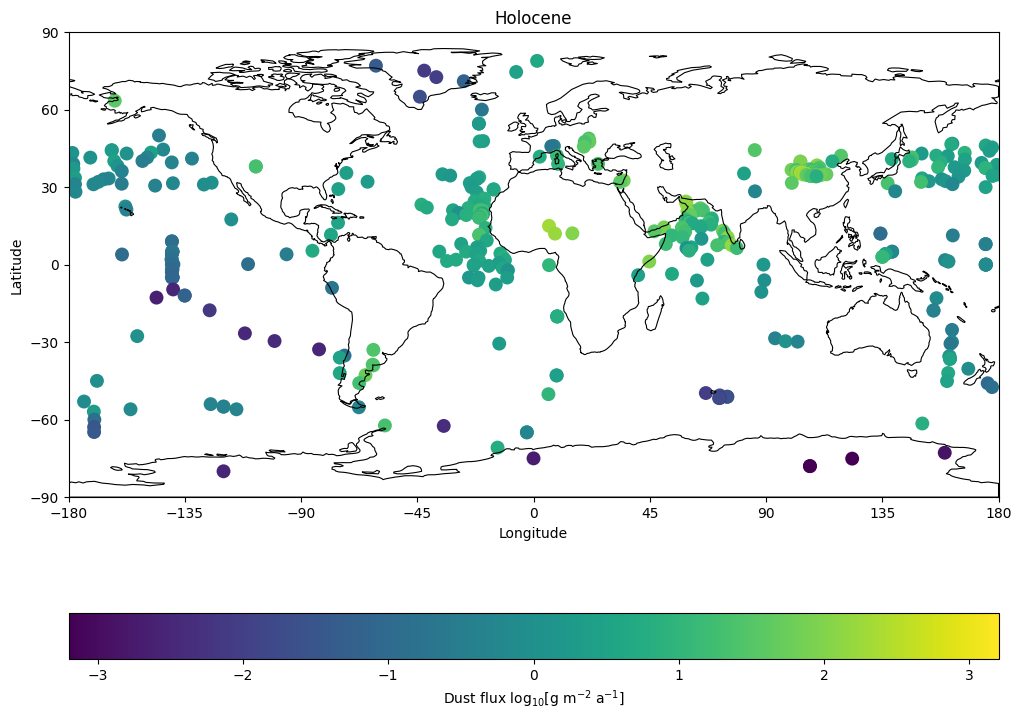

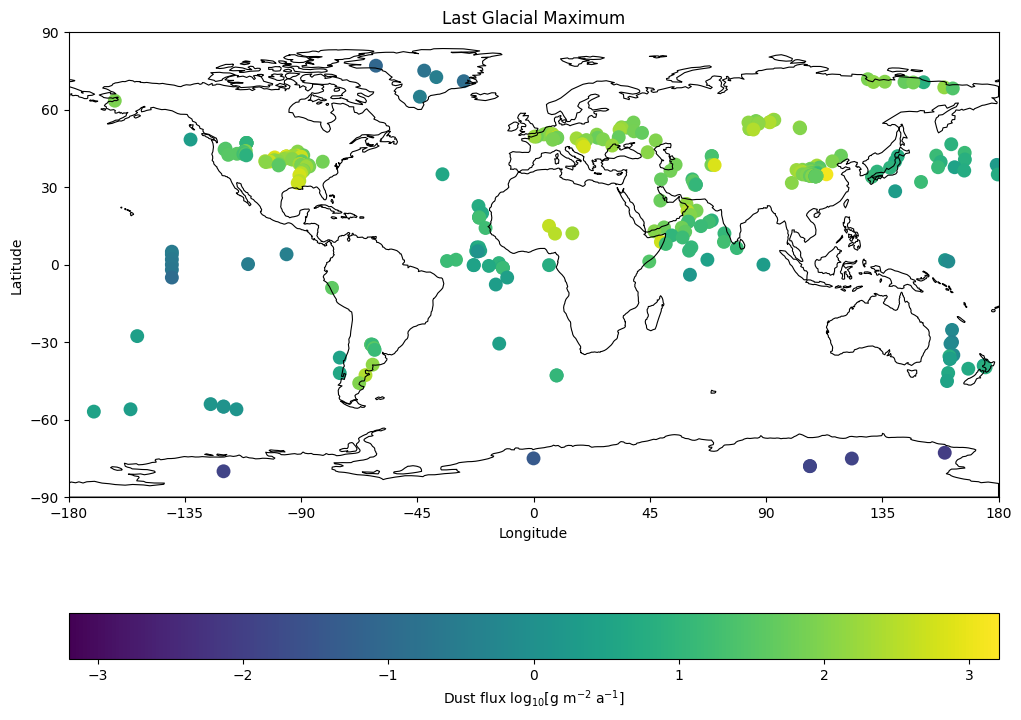

In [ ]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [ ]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

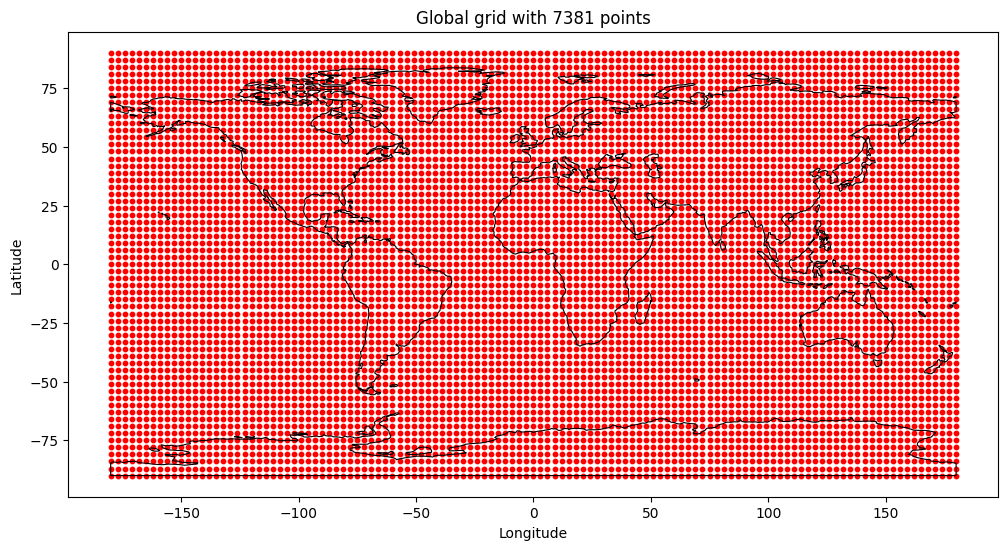

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [ ]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [ ]:
from math import radians

In [ ]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    lon1, lat1 = x
    lon2, lat2 = y

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    earth_ratio = 6373

    distance = earth_ratio * np.arccos(np.sin(lat1) * np.sin(lat2) + (np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)))
    return distance

In [ ]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """

    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean

    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))

    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]

    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)

    return estimation

In [ ]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [ ]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

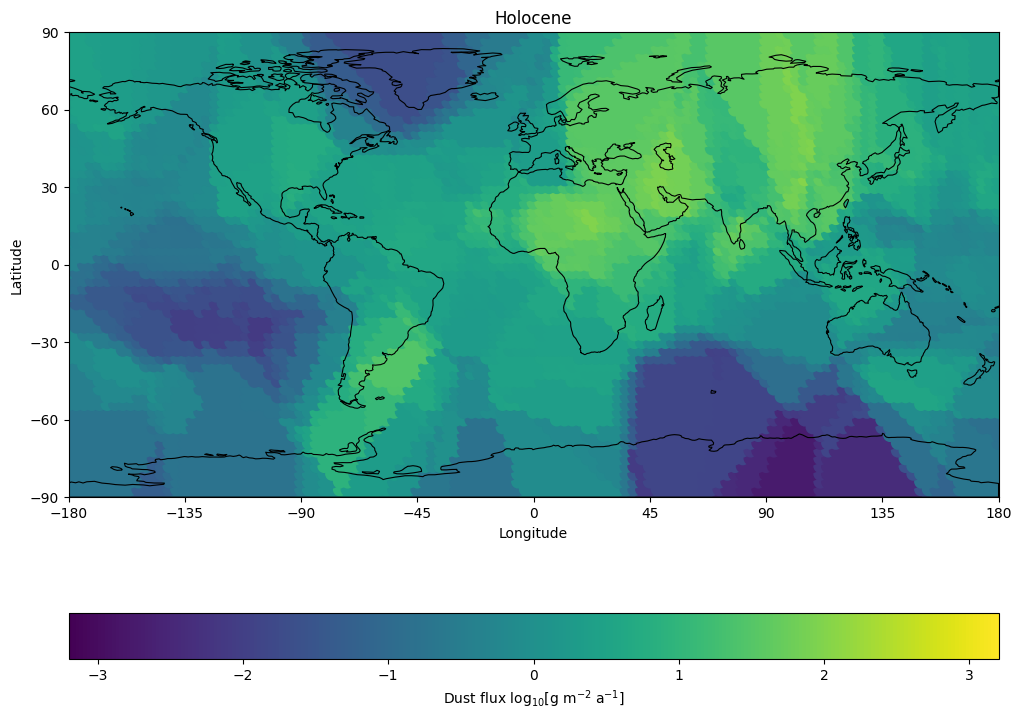

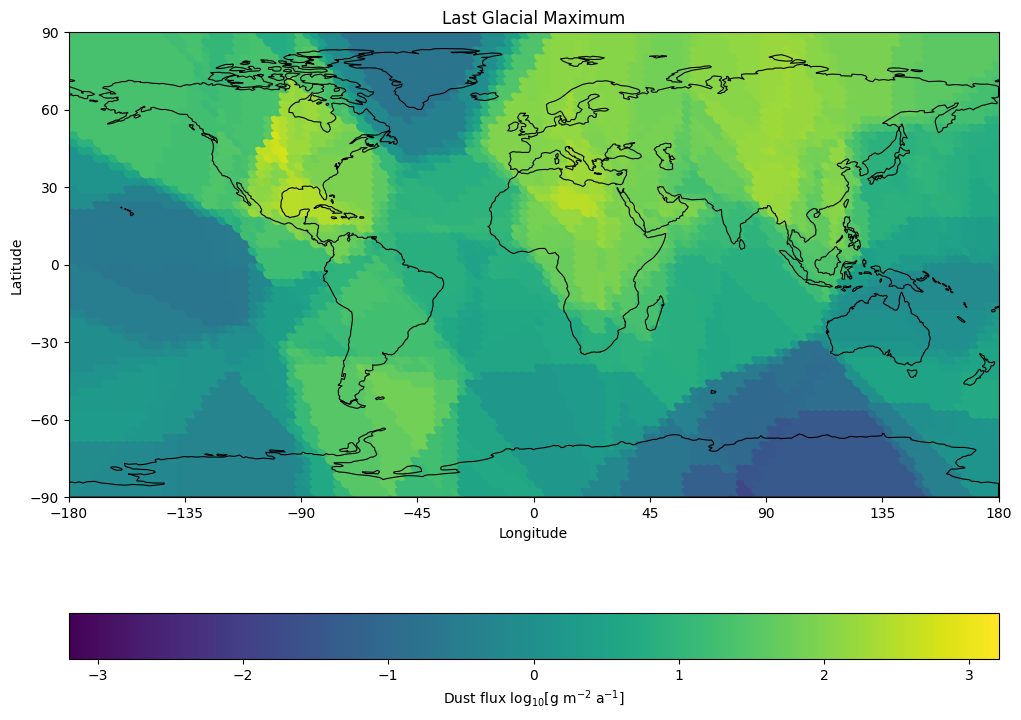

In [ ]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='EUCLIDEAN_ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='EUCLIDEAN_ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [ ]:
estimations_holocene_geod = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geod = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geod[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geod[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geo"] = estimations_holocene_geod
df_global_grid["est_lgm_geo"] = estimations_lgm_geod

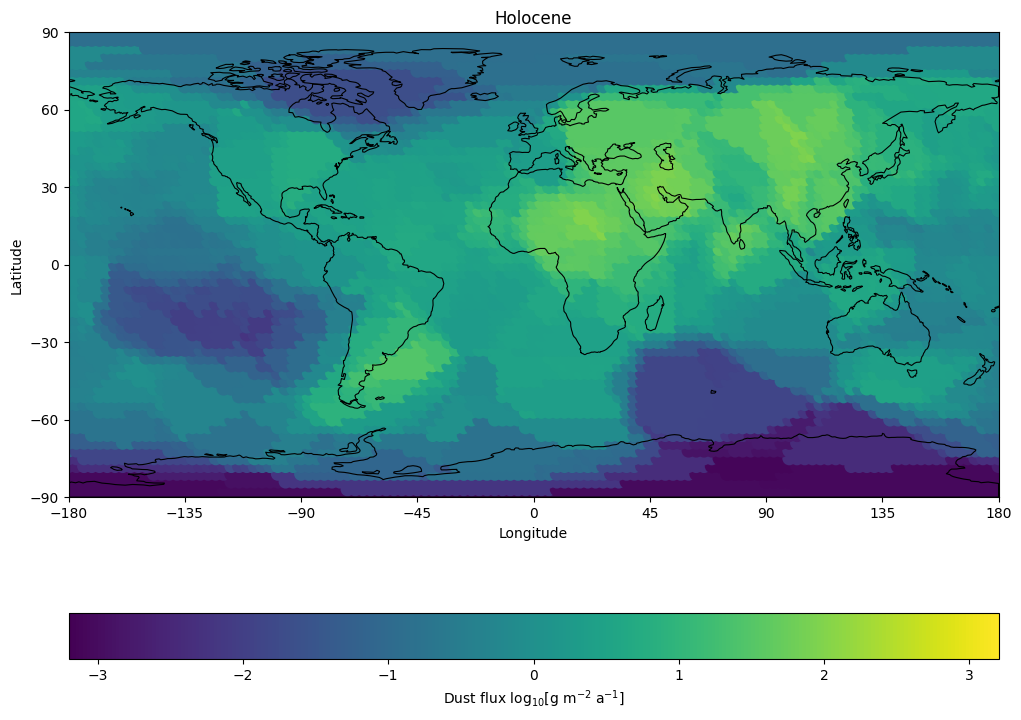

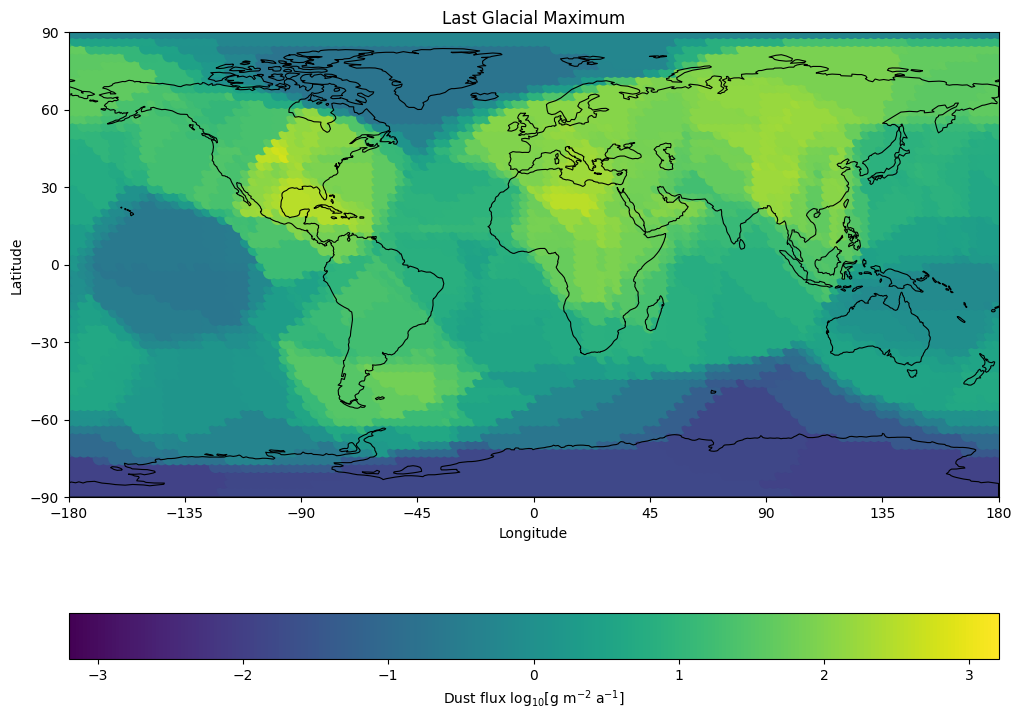

In [ ]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='GEODESIC_ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_geo')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='GEODESIC_ESTIMATION_MAP_LGM',
                         label_str='est_lgm_geo')

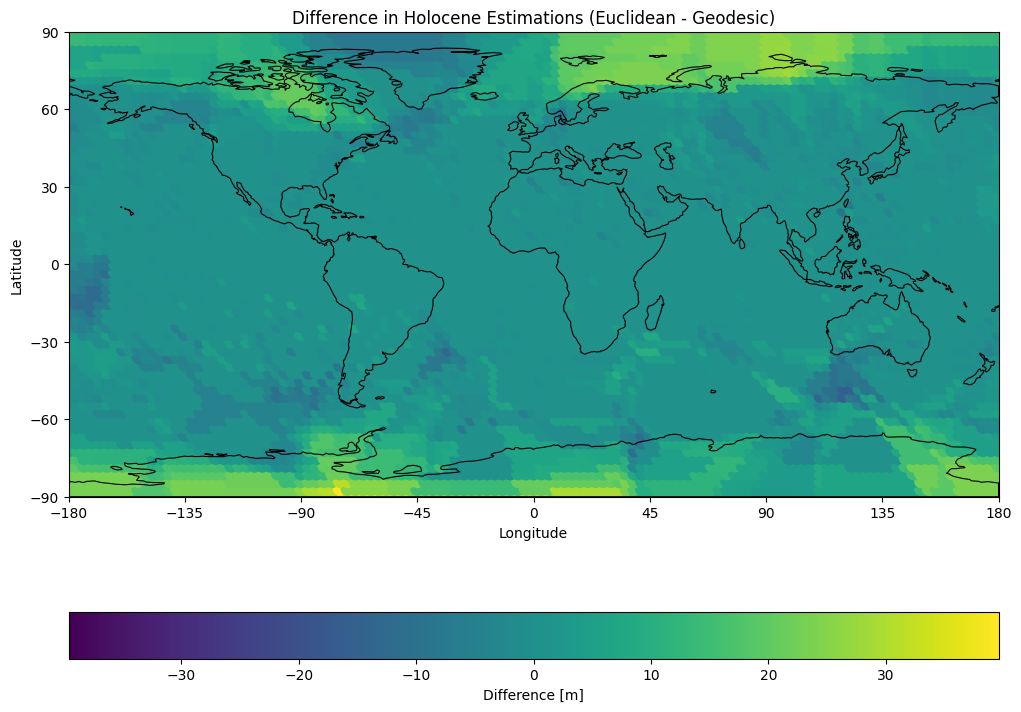

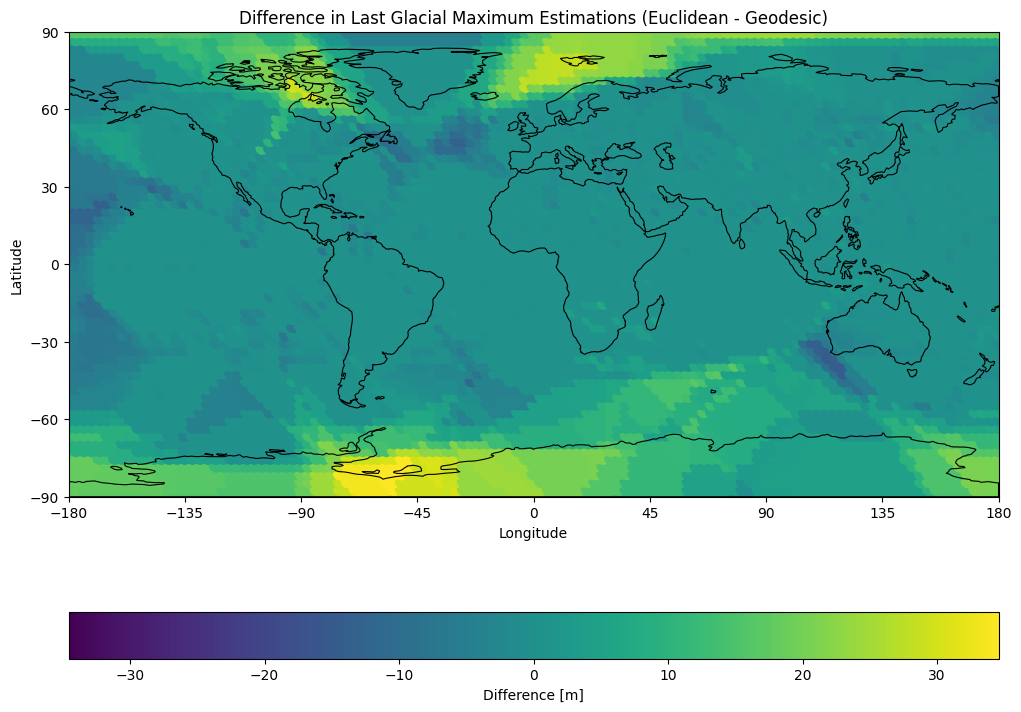

In [38]:
"""
Código hecho con ChatGPT
para representar en un mapa la diferencia entre las estimaciones realizadas
con distancia euclideana y distancia geodesica
"""

# Calcular las diferencias entre las estimaciones
differences_holocene = estimations_holocene - estimations_holocene_geod
differences_lgm = estimations_lgm - estimations_lgm_geod

# Densidad del polvo en g/cm^3 y espesor de la capa de polvo en cm
density_dust_g_cm3 = 1
thickness_dust_cm = 1

# Convertir la densidad del polvo a g/m^3 y el espesor de la capa de polvo a metros
density_dust_g_m3 = density_dust_g_cm3 * 1000  # 1 g/cm^3 = 1000 g/m^3
thickness_dust_m = thickness_dust_cm / 100  # 1 cm = 0.01 m

# Calcular el volumen de polvo por área en m^2
volume_dust_m2 = density_dust_g_m3 * thickness_dust_m

# Convertir las diferencias de masa de polvo por área a metros
differences_holocene_m = differences_holocene * volume_dust_m2
differences_lgm_m = differences_lgm * volume_dust_m2

# Agregar las diferencias convertidas al DataFrame
df_global_grid["diff_hol_m"] = differences_holocene_m
df_global_grid["diff_lgm_m"] = differences_lgm_m

# Encontrar los valores máximos de las diferencias convertidas
max_diff_holocene_m = np.max(np.abs(differences_holocene_m))
max_diff_lgm_m = np.max(np.abs(differences_lgm_m))

# Visualizar las diferencias en un mapa
plot_dust_deposition_map(df=df_global_grid,
                         title='Difference in Holocene Estimations (Euclidean - Geodesic)',
                         name_to_save='DIFFERENCE_MAP_HOLOCENE',
                         label_str='diff_hol_m',
                         measure_units='Difference [m]',
                         limit_bar=max_diff_holocene_m)

plot_dust_deposition_map(df=df_global_grid,
                         title='Difference in Last Glacial Maximum Estimations (Euclidean - Geodesic)',
                         name_to_save='DIFFERENCE_MAP_LGM',
                         label_str='diff_lgm_m',
                         measure_units='Difference [m]',
                         limit_bar=max_diff_lgm_m)


In [37]:
# Diferencia máxima y diferencia promedio entre el cálculo con distancia euclidiana y distancia geodésica
average_difference_holocene = np.mean(differences_holocene_m)
average_difference_lgm = np.mean(differences_lgm_m)

print(f"Diferencia máxima Holoceno: {max_diff_holocene_m:.2f} [m]")
print(f"Diferencia máxima LGM: {max_diff_lgm_m:.2f} [m]")

print(f"Promedio de diferencias Holoceno: {average_difference_holocene:.2f} [m]")
print(f"Promedio de diferencias LGM: {average_difference_lgm:.2f} [m]")

Diferencia máxima Holoceno: 39.59 [m]
Diferencia máxima LGM: 34.58 [m]
Promedio de diferencias Holoceno: 3.10 [m]
Promedio de diferencias LGM: 3.26 [m]


La elección entre la distancia euclidiana y la geodésica para visualizar la sedimentación de polvo en diferentes partes del mundo puede tener un impacto significativo en los resultados. La diferencia principal radica en cómo cada método maneja la distorsión de las distancias en un mapa plano en comparación con la superficie curva de la Tierra.

En el ecuador, donde la distorsión de un mapa plano es mínima, las diferencias entre los dos métodos pueden ser menos notables. Sin embargo, cerca de los polos, donde la distorsión es más pronunciada al convertir la superficie esférica en un plano, las diferencias pueden ser más significativas.

La distancia geodésica, al tener en cuenta la curvatura de la Tierra, es más fidedigna en los polos sur y norte. Por otro lado, en el ecuador y zonas cercanas, donde la distorsión es mínima, la distancia euclidiana puede ser igual de precisa que la euclideana.